## Importations

In [9]:
import pandas as pd
from math import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import dateutil.parser
import re
import time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from scipy import stats as stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
import statsmodels.api as sm
import statsmodels.tsa.stattools as tsa

pd.set_option('display.max_columns', 80)
pd.set_option('expand_frame_repr', True)

%matplotlib inline
sns.set_palette("hls")
import bandits as ba

## Fonctions additionnelles :

In [10]:
def calcul_freq(data,res_linucb):

    liste_appli = ['bt','cg','ep','ft','is','lu','mg','sp']
    frequences = [1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4]
    
    temps_execution = []
    consommations = []
    best_consos = []
    
    best_freq = [] # On stocke la frequences optimale
    gains = [] # On stocke les gains moyens
    
    for k in range(len(liste_appli)) :
        app = liste_appli[k]
        print('Appli :', app)
        # Calcul des temps moyens :

        indices_app = np.where(data['name'] == app)[0] #On récupère les indices associés à l'application
        n = data.shape[0]
        temps = np.zeros(13)

        for i in range(n):
            if i in indices_app :
                for j in range(13):
                    
                    temps[j] += data.iat[i,j+1]

        temps /= len(indices_app)
        temps_execution.append(temps)
        
        # Calcul de la consommation prévue
        
        consos = []
        for i in range(13):
            c = res_linucb.iat[i,k]
            d = res_linucb.iat[i,-1]
        

            energie = abs(c + temps[i]*d)
            consos.append(energie)
            print("Consommation pour " + str(frequences[i]) + " GHz :" + str(energie))
        print('')
        consommations.append(consos)
        indices_min = np.argmin(consos)
        best_consos.append(min(consos))

        best_freq.append(frequences[indices_min])
        
        # Construction du tableau recaptulatif :
        
        consos.remove(best_consos[-1])
        moy = np.mean(consos)

        if moy == 0 :
            gains.append('NA')
        else :
            gains.append(moy - best_consos[-1])
        
    a = np.array([best_freq, best_consos, gains])
    a = np.transpose(a)
    recap = pd.DataFrame(data=a, index=liste_appli, columns=['Frequence optimale', 'Consommation optimale', 'Gain moyen'])
    return [recap, temps_execution, consommations]

## Traitement données

In [11]:
path = '/home/agary/Documents/Data/npb_fast/02_remove_wm/'
filename = 'raw_data.csv'

df = pd.read_csv(path + filename)
data = df.drop(labels=0,axis=0)
data = data.drop(columns=['Unnamed: 0'])

dt = pd.get_dummies(data['name'])
dt['duration'] = data['duration']

rewards = (-1)*data[data.columns[14:27]]

In [12]:
dt.head()

bt  cg  ep  ft  is  lu  mg  sp  duration
1   0   0   0   0   0   1   0   0     28.63
2   0   0   0   0   1   0   0   0     15.86
3   0   0   0   1   0   0   0   0     11.73
4   0   0   0   0   1   0   0   0     15.86
5   0   0   0   0   0   0   0   1     27.80

In [13]:
rewards.head()

ref_energy  ref_energy.1  ref_energy.2  ref_energy.3  ref_energy.4  \
1    -4638.06      -4382.08      -4131.74     -4039.200     -3973.810   
2    -2394.86      -2330.20      -2337.40     -2277.600     -2319.840   
3    -1865.07      -1773.90      -1754.62     -1674.860     -1648.115   
4    -2339.35      -2360.56      -2342.05     -2248.775     -2217.605   
5    -5309.80      -5177.16      -5075.00     -4908.980     -4811.100   

   ref_energy.5  ref_energy.6  ref_energy.7  ref_energy.8  ref_energy.9  \
1      -3859.20     -3792.500      -3732.75      -3625.18      -3564.60   
2      -2371.07     -2375.290      -2331.60      -2319.21      -2336.71   
3      -1579.30     -1572.080      -1601.25      -1582.02      -1360.41   
4      -2236.80     -2282.245      -2246.16      -2271.49      -2293.92   
5      -4788.72     -4732.200      -4657.56      -4644.42      -4636.17   

   ref_energy.10  ref_energy.11  ref_energy.12  
1      -3522.000      -3461.150       -3402.28  
2      -2274.265      -2320.920       -2305.92  
3      -1568.000      -1374.560       -1436.32  
4      -2285.830      -2250.835       -2239.28  
5      -4572.360      -4564.890       -4568.96

In [14]:
df.describe()

duration    duration.1    duration.2    duration.3    duration.4  \
count  7.840000e+02  7.840000e+02  7.840000e+02  7.840000e+02  7.840000e+02   
mean   1.551714e+03  1.678144e+03  1.804756e+03  1.931518e+03  2.058405e+03   
std    4.285639e+04  4.642786e+04  4.999932e+04  5.357078e+04  5.714223e+04   
min    7.340000e+00  6.770000e+00  6.290000e+00  5.880000e+00  5.510000e+00   
25%    8.237500e+00  7.387500e+00  7.422500e+00  7.040000e+00  6.680000e+00   
50%    2.179500e+01  2.103000e+01  2.008500e+01  1.912000e+01  1.837000e+01   
75%    2.880000e+01  2.786000e+01  2.719500e+01  2.674500e+01  2.632000e+01   
max    1.200000e+06  1.300000e+06  1.400000e+06  1.500000e+06  1.600000e+06   

         duration.5    duration.6    duration.7    duration.8    duration.9  \
count  7.840000e+02  7.840000e+02  7.840000e+02  7.840000e+02  7.840000e+02   
mean   2.185379e+03  2.312462e+03  2.439524e+03  2.566654e+03  2.693824e+03   
std    6.071368e+04  6.428512e+04  6.785657e+04  7.142801e+04  7.499946e+04   
min    5.190000e+00  4.900000e+00  4.630000e+00  4.400000e+00  4.190000e+00   
25%    6.577500e+00  6.565000e+00  6.425000e+00  6.495000e+00  6.220000e+00   
50%    1.779500e+01  1.712000e+01  1.657000e+01  1.609000e+01  1.557500e+01   
75%    2.608000e+01  2.585250e+01  2.572250e+01  2.556000e+01  2.544250e+01   
max    1.700000e+06  1.800000e+06  1.900000e+06  2.000000e+06  2.100000e+06   

        duration.10   duration.11   duration.12    ref_energy  ref_energy.1  \
count  7.840000e+02  7.840000e+02  7.840000e+02  7.840000e+02  7.840000e+02   
mean   2.821020e+03  2.948218e+03  3.075443e+03  5.298510e+03  5.304227e+03   
std    7.857090e+04  8.214234e+04  8.571378e+04  4.278119e+04  4.634917e+04   
min    3.990000e+00  3.820000e+00  3.670000e+00  8.339400e+02  8.080100e+02   
25%    6.525000e+00  6.412500e+00  6.477500e+00  1.484775e+03  1.443710e+03   
50%    1.510500e+01  1.462500e+01  1.424000e+01  3.541520e+03  3.419855e+03   
75%    2.498500e+01  2.404250e+01  2.316250e+01  6.337977e+03  6.241200e+03   
max    2.200000e+06  2.300000e+06  2.400000e+06  1.200000e+06  1.300000e+06   

       ref_energy.2  ref_energy.3  ref_energy.4  ref_energy.5  ref_energy.6  \
count  7.840000e+02  7.840000e+02  7.840000e+02  7.840000e+02  7.840000e+02   
mean   5.331180e+03  5.377295e+03  5.430877e+03  5.555831e+03  5.660764e+03   
std    4.991835e+04  5.348826e+04  5.705862e+04  6.062818e+04  6.419787e+04   
min    7.749000e+02  7.187400e+02  6.568800e+02  6.356200e+02  6.137500e+02   
25%    1.419941e+03  1.411230e+03  1.372852e+03  1.400513e+03  1.421984e+03   
50%    3.309420e+03  3.220320e+03  3.129730e+03  3.120010e+03  3.091530e+03   
75%    6.087625e+03  5.853887e+03  5.668868e+03  5.585932e+03  5.489773e+03   
max    1.400000e+06  1.500000e+06  1.600000e+06  1.700000e+06  1.800000e+06   

       ref_energy.7  ref_energy.8  ref_energy.9  ref_energy.10  ref_energy.11  \
count  7.840000e+02  7.840000e+02  7.840000e+02   7.840000e+02   7.840000e+02   
mean   5.736536e+03  5.831467e+03  5.931599e+03   6.036213e+03   6.145638e+03   
std    6.776926e+04  7.134011e+04  7.491115e+04   7.848219e+04   8.205324e+04   
min    5.697400e+02  5.271700e+02  5.139450e+02   4.800000e+02   4.754750e+02   
25%    1.404300e+03  1.403202e+03  1.390406e+03   1.394497e+03   1.397370e+03   
50%    3.033885e+03  2.982690e+03  2.954670e+03   2.921400e+03   2.898790e+03   
75%    5.361222e+03  5.261738e+03  5.176285e+03   5.060788e+03   5.004136e+03   
max    1.900000e+06  2.000000e+06  2.100000e+06   2.200000e+06   2.300000e+06   

       ref_energy.12  
count   7.840000e+02  
mean    6.276548e+03  
std     8.562380e+04  
min     4.464900e+02  
25%     1.407995e+03  
50%     2.886520e+03  
75%     4.971220e+03  
max     2.400000e+06

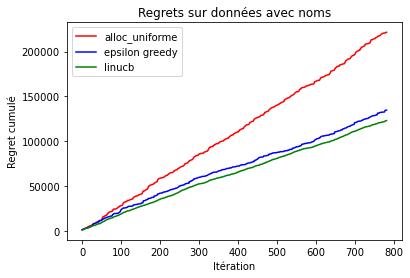

In [15]:
alloc_unif = ba.UniformBandit(rewards)
alloc_eps_greedy = ba.EpsilonGreedy(rewards)
alloc_linucb = ba.LINUCB(dt,rewards)

reg_unif = ba.cumulativeRegret(alloc_unif[1],rewards)
reg_eps_greedy = ba.cumulativeRegret(alloc_eps_greedy[1],rewards)
reg_linucb = ba.cumulativeRegret(alloc_linucb[3],rewards)

plt.plot(reg_unif, 'r', label = 'alloc_uniforme');
plt.plot(reg_eps_greedy, 'b', label = 'epsilon greedy');
plt.plot(reg_linucb, 'g', label = 'linucb');
plt.xlabel('Itération');
plt.ylabel('Regret cumulé');
plt.title('Regrets sur données avec noms');
plt.legend();
plt.show();

La méthode proposant un regret optimal est l'algorithme LINUCB : Le travail sera donc effecuté avec celui-ci.

## Exploitation des résultats de LINUCB

In [16]:
res_linucb = alloc_linucb[1]
print("theta hat")
res_linucb

theta hat


bt          cg          ep          ft          is  \
ref_energy       0.000000    0.000000    0.000000    0.000000    0.000000   
ref_energy.1     0.000000    0.000000    0.000000    0.000000  507.490282   
ref_energy.2     0.000000  180.472471    0.000000  322.622631    0.000000   
ref_energy.3     0.000000  169.975323    0.000000    0.000000  577.556272   
ref_energy.4     0.000000    0.000000    0.000000    0.000000    0.000000   
ref_energy.5     0.000000  242.589958  374.489256  377.881212    0.000000   
ref_energy.6     0.000000  171.584259    0.000000    0.000000    0.000000   
ref_energy.7     0.000000    0.000000    0.000000    0.000000    0.000000   
ref_energy.8   867.558983 -140.193945  498.488031  238.442759  130.089318   
ref_energy.9     0.000000  236.413450    0.000000    0.000000    0.000000   
ref_energy.10    0.000000   68.285907    0.000000    0.000000  504.643810   
ref_energy.11    0.000000  -34.943656    0.000000    0.000000  229.933156   
ref_energy.12    0.000000    0.000000    0.000000    0.000000    0.000000   

                        lu           mg          sp    duration  
ref_energy      578.747727  -577.952808    0.000000 -202.429460  
ref_energy.1      0.000000  -295.386867    0.000000 -210.919329  
ref_energy.2      0.000000  -480.951296  306.096751 -204.592094  
ref_energy.3      0.000000  -595.847021  243.287447 -200.515186  
ref_energy.4      0.000000  -445.751978  454.239042 -205.740219  
ref_energy.5      0.000000  -595.459162  288.452650 -200.496425  
ref_energy.6      0.000000   -53.677946    0.000000 -220.696090  
ref_energy.7    861.728324  -844.975700    0.000000 -192.998833  
ref_energy.8    723.829788 -1960.904060 -448.317297 -154.386319  
ref_energy.9      0.000000  -518.352867  470.848627 -206.755312  
ref_energy.10     0.000000  -737.636131  454.190242 -196.370667  
ref_energy.11  1119.991090 -1236.602122    0.000000 -178.795480  
ref_energy.12     0.000000  -459.281658  490.393106 -207.764633

In [17]:
print('theta exact')
alloc_linucb[2]

theta exact


bt           cg          ep           ft           is  \
ref_energy      522.602883    29.896091  321.427448   239.756757   479.853652   
ref_energy.1  -4967.520928 -1003.849346 -662.708135 -1344.488708 -1759.309766   
ref_energy.2  -4490.996701  -934.397725 -566.581386 -1231.908912 -1649.085870   
ref_energy.3  -5139.158180 -1075.774505 -670.735054 -1430.384701 -1954.546035   
ref_energy.4  -4763.685689 -1025.204775 -592.862465 -1342.302909 -1863.852472   
ref_energy.5  -4859.187531 -1075.804450 -579.628957 -1388.431949 -1968.635108   
ref_energy.6  -4728.892197 -1118.525270 -551.787375 -1376.702212 -1984.761235   
ref_energy.7  -4368.612078 -1051.560455 -463.883923 -1264.967108 -1873.733276   
ref_energy.8  -3803.514041  -993.100589 -350.483394 -1100.705636 -1685.936804   
ref_energy.9  -4258.247209 -1089.894940 -409.350535 -1241.298509 -1906.605903   
ref_energy.10 -3947.111462 -1069.433976 -332.230367 -1147.297999 -1813.402541   
ref_energy.11 -4190.588752 -1126.765142 -375.099070 -1214.222088 -1930.989180   
ref_energy.12 -3640.084671 -1072.762804 -257.228776 -1045.002294 -1742.817328   

                        lu           mg           sp    duration  
ref_energy      491.443842 -1278.765066  -353.296205 -181.503708  
ref_energy.1  -3367.704153 -5338.335558 -4185.671787  -39.049219  
ref_energy.2  -3041.130439 -5159.954498 -3908.625521  -44.055947  
ref_energy.3  -3490.731504 -5766.284291 -4388.784244  -22.841120  
ref_energy.4  -3239.477754 -5645.694649 -4169.090098  -26.901041  
ref_energy.5  -3299.783886 -5861.599016 -4272.817999  -22.867091  
ref_energy.6  -3202.838586 -5890.597690 -4230.243473  -23.123563  
ref_energy.7  -2948.559426 -5756.166066 -3994.409490  -28.752218  
ref_energy.8  -2560.493299 -5478.164787 -3650.990920  -39.649759  
ref_energy.9  -2879.877752 -5916.271289 -3993.085452  -26.099493  
ref_energy.10 -2654.853550 -5796.777611 -3823.798859  -31.598151  
ref_energy.11 -2830.817850 -6078.460695 -4023.430015  -23.731795  
ref_energy.12 -2448.220489 -5788.757613 -3675.668376  -36.338489

In [18]:
recap, temps_execution, consommations = calcul_freq(data, res_linucb)

Appli : bt
Consommation pour 1.2 GHz :8256.470162190551
Consommation pour 1.3 GHz :8038.937135676477
Consommation pour 1.4 GHz :7330.002789690919
Consommation pour 1.5 GHz :6802.878717569117
Consommation pour 1.6 GHz :6627.880001712481
Consommation pour 1.7 GHz :6169.295054168644
Consommation pour 1.8 GHz :6515.522387808147
Consommation pour 1.9 GHz :5466.653345830264
Consommation pour 2.0 GHz :3331.6717128461487
Consommation pour 2.1 GHz :5413.412311950817
Consommation pour 2.2 GHz :4949.071003639904
Consommation pour 2.3 GHz :4333.483926442854
Consommation pour 2.4 GHz :4847.709851804947

Appli : cg
Consommation pour 1.2 GHz :1502.419062140174
Consommation pour 1.3 GHz :1500.669506074714
Consommation pour 1.4 GHz :1221.7766896988553
Consommation pour 1.5 GHz :1167.5018896347608
Consommation pour 1.6 GHz :1340.5444830065085
Consommation pour 1.7 GHz :1038.3776109364358
Consommation pour 1.8 GHz :1217.4048672309953
Consommation pour 1.9 GHz :1200.9647791717434
Consommation pour 2.0 GHz

In [19]:
print('Recapitulatif des resultats :')
recap

Recapitulatif des resultats :


Frequence optimale  Consommation optimale   Gain moyen
bt                 2.0            3331.671713  2897.604678
cg                 2.1            1026.840410   204.548272
ep                 2.0             190.948250   843.054201
ft                 2.0            1074.902362   753.132021
is                 2.0            1897.548867   764.851028
lu                 2.3            1907.508985  2265.119612
mg                 2.4            5852.418687   181.052242
sp                 2.2            3411.396701   927.945845

## Compraison avec UCB pour chaque bras

In [20]:
def list_ucb(data,liste_appli,frequences):
    
    # stockage des fréquences optimale pour chaque application
    freq_opti = np.zeros(len(liste_appli))
    regrets = []
    i = 0
    for app in liste_appli :
        
        # preparation données
        df_app = data.loc[data['name'] == app]
        rewards_app = (-1) * df_app[df_app.columns[14:27]]

        # ucb
        ucb_app = ba.UCB(rewards_app)
        
        # Localisation du meilleur bras
        theta_hat = np.array(ucb_app[4])
        best_arm = np.argmax(ucb_app[4])
        freq_opti[i] = frequences[best_arm]
        print("Nom de l'application : ", app)
        print("Fréquence optimale :", freq_opti[i])

        # calcul regret
        reg = ba.cumulativeRegret(ucb_app[1],rewards_app)
        regrets.append(reg)
        
        i += 1
    res = pd.DataFrame(data=freq_opti,index=liste_appli,columns=['Fréquence optimale'])
    return res,regrets

In [21]:
liste_appli = ['bt','cg','ep','ft','is','lu','mg','sp']
frequences = [1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3,2.4]

ucb_bras, regrets = list_ucb(data,liste_appli,frequences)

Nom de l'application :  bt
Fréquence optimale : 2.3
Nom de l'application :  cg
Fréquence optimale : 1.5
Nom de l'application :  ep
Fréquence optimale : 2.3
Nom de l'application :  ft
Fréquence optimale : 2.4
Nom de l'application :  is
Fréquence optimale : 2.4
Nom de l'application :  lu
Fréquence optimale : 2.3
Nom de l'application :  mg
Fréquence optimale : 1.5
Nom de l'application :  sp
Fréquence optimale : 2.3


/home/agary/Documents/Python/bandits.py:381: RuntimeWarning: invalid value encountered in double_scalars
  choice[j] = S[0,j] + alpha*sqrt(2*log(iter+1)/S[1,j])
/home/agary/Documents/Python/bandits.py:381: RuntimeWarning: divide by zero encountered in double_scalars
  choice[j] = S[0,j] + alpha*sqrt(2*log(iter+1)/S[1,j])


In [22]:
ucb_bras

Fréquence optimale
bt                 2.3
cg                 1.5
ep                 2.3
ft                 2.4
is                 2.4
lu                 2.3
mg                 1.5
sp                 2.3

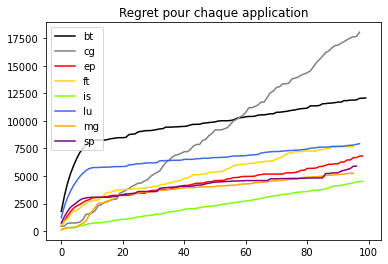

In [23]:
colors = ['black','grey','red','gold','chartreuse','royalblue','orange','purple']
cum_regret = np.zeros(1)
for i in range(len(regrets)):
    app = liste_appli[i]
    plt.plot(regrets[i],label = app,color=colors[i]);
    plt.title('Regret pour chaque application');
    plt.legend();
    cum_regret = np.concatenate((cum_regret,regrets[i]))
plt.show();

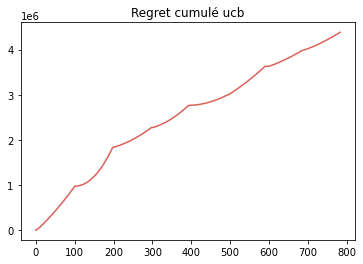

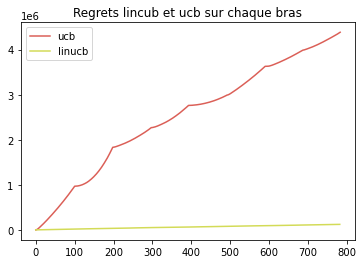

In [24]:
cum_regret = np.cumsum(cum_regret)
plt.plot(cum_regret);
plt.title('Regret cumulé ucb');
plt.show();


plt.plot(cum_regret, label='ucb');
plt.plot(reg_linucb, label='linucb');
plt.title('Regrets lincub et ucb sur chaque bras');
plt.legend();
plt.show();